# Goal
Create matched paires and conduct matching paires Wilcoxon test with CLR transformed metagenomes

# Libraries

In [66]:
library(MatchIt)
library(optmatch)
library(PairedData)
library(microbiome)
library(dplyr)
library(phyloseq)
library(ggplot2)
library(plyr)
library(zCompositions)
library(compositions)
library(textshape)
library(tibble)
library(gcookbook)
library(tidyverse)
library("varhandle")

In [67]:
source("./Wilcoxon_Sign_Rank_Test_v2.R")

# Load

In [68]:
load("psq3.RData")
load("filt_psq.RData")
load('phyloseq-psor-control-metagenome.RData')

In [69]:
psq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 424 taxa and 100 samples ]
sample_data() Sample Data:       [ 100 samples by 56 sample variables ]
tax_table()   Taxonomy Table:    [ 424 taxa by 7 taxonomic ranks ]

# Analysis

NEAREST NEIGHBOR MATCHING - WITHOUT computing Propensity Score

MATCHED-PAIR CONSTRUCTION based on FAMILY-level PCs

In [111]:
# ("Kingdom", "Phylum", "Class","Order", "Family","Genus","Species")
comp_psq <- microbiome::transform(psq1, "compositional")
comp_psq_family <- aggregate_taxa(comp_psq, level = "Family")
ord_family <- ordinate(comp_psq_family, "PCoA", "bray")

In [112]:
eigs_family <- ord_family$values
eigs_family$Eigenvalues[1]/sum(eigs_family$Eigenvalues)*100
#69.37967

[1] 69.37967

In [113]:
eigs_family$Eigenvalues[2]/sum(eigs_family$Eigenvalues)*100
# 69.37967+12.29686 = 81.67653

[1] 12.29686

In [114]:
id_diagnosis <- sample_data(comp_psq)[,c('ID','Diagnosis')]
class(id_diagnosis) #sample_data

[1] "sample_data"
attr(,"package")
[1] "phyloseq"

In [115]:
class(id_diagnosis) <- c("data.frame")

PC_coords <- ord_family$vectors

head(id_diagnosis)

,ID,Diagnosis
,<chr>,<chr>
D9_profile,D9_profile,control
D99_profile,D99_profile,control
D98_profile,D98_profile,control
D97_profile,D97_profile,control
D96_profile,D96_profile,control
D95_profile,D95_profile,control


In [116]:
ids_pcs <- data.frame(IDs=c(row.names(PC_coords)),PC_coords[,1:3])
ids_pcs[1:3,]

,IDs,Axis.1,Axis.2,Axis.3
,<chr>,<dbl>,<dbl>,<dbl>
D9_profile,D9_profile,-0.1525980,-0.07106407,0.000130203
D99_profile,D99_profile,-0.2198335,0.15713327,0.013817484
D98_profile,D98_profile,-0.1298013,-0.05297474,-0.054765595


In [117]:
PCs_status <- merge(x=id_diagnosis, y=ids_pcs, by.x='ID', by.y='IDs',sort=F)

PCs_status[1:3,1:5]

,ID,Diagnosis,Axis.1,Axis.2,Axis.3
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,D9_profile,control,-0.1525980,-0.07106407,0.000130203
2,D99_profile,control,-0.2198335,0.15713327,0.013817484
3,D98_profile,control,-0.1298013,-0.05297474,-0.054765595


In [118]:
PCs_status$Diagnosis <- as.factor(PCs_status$Diagnosis)

In [119]:
# 1) Check Imbalance

psom.out0 <- matchit(Diagnosis ~ Axis.1 + Axis.2, data = PCs_status, method = NULL, distance = "glm")

# Checking balance prior to matching

summary(psom.out0)
# Quite well balanced


Call:
matchit(formula = Diagnosis ~ Axis.1 + Axis.2, data = PCs_status, 
    method = NULL, distance = "glm")

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance        0.5309        0.5290          0.0859     1.0417    0.0556
Axis.1         -0.0060        0.0067         -0.0408     0.9931    0.0306
Axis.2          0.0047       -0.0053          0.0774     0.9690    0.0377
         eCDF Max
distance   0.1690
Axis.1     0.1224
Axis.2     0.0943

Sample Sizes:
          Control Treated
All            47      53
Matched        47      53
Unmatched       0       0
Discarded       0       0


###  NEAREST NEIGHBOR MATCHING - WITHOUT computing Propensity Score

RAW Euclidean distances are used to find matches:

In [120]:
psomNN_euclidean <- matchit(Diagnosis ~ Axis.1 + Axis.2, data = PCs_status, method = "nearest", distance = "euclidean", replace=T)

nrow(psomNN_euclidean$match.matrix)

[1] 53

In [121]:
NODUPS_psomNN_euclidean <- matchit(Diagnosis ~ Axis.1 + Axis.2, data = PCs_status, method = "nearest", distance = "euclidean", replace=F)

uniq_matches <- NODUPS_psomNN_euclidean$match.matrix[c(!is.na(NODUPS_psomNN_euclidean$match.matrix)),]

Warning message:
"Fewer control units than treated units; not all treated units will get a match."


 extract pairs - NN on Euclidean distance based on PC1 and PC2

 psomNN_euclidean$match.matrix

In [122]:
# RAW Euclidean distances are used to find matches:

Euclid_NN_pair_index <- data.frame(treated=row.names(psomNN_euclidean$match.matrix), control=psomNN_euclidean$match.matrix)

Uniq_Euclid_NN_pair_index <- data.frame(treated=names(uniq_matches), control=uniq_matches)

nrow(Euclid_NN_pair_index)

[1] 53

In [123]:
Euclid_NN_pair_index[1:3,]
nrow(Uniq_Euclid_NN_pair_index)


,treated,control
,<chr>,<chr>
21,21,34
22,22,77
24,24,34


[1] 47

In [124]:
Uniq_Euclid_NN_pair_index[1:3,]

,treated,control
,<chr>,<chr>
21,21,34
22,22,77
24,24,12


In [125]:
# replace with sample IDs

Eucl_NN_pairIDs=cbind(PCs_status$ID[as.numeric(Euclid_NN_pair_index$treated)],PCs_status$ID[as.numeric(Euclid_NN_pair_index$control)])

Eucl_NN_pairIDs[1:5,]
# All pairs are maximally close to each other!!!
# Good solution

D81_profile,D6_profile
D80_profile,D30_profile
D79_profile,D6_profile
D78_profile,D85_profile
D77_profile,D86_profile


In [126]:
Uniq_Eucl_NN_pairIDs<- cbind(PCs_status$ID[as.numeric(Uniq_Euclid_NN_pair_index$treated)],PCs_status$ID[as.numeric(Uniq_Euclid_NN_pair_index$control)])

Uniq_Eucl_NN_pairIDs[1:5,]

D81_profile,D6_profile
D80_profile,D30_profile
D79_profile,D8_profile
D78_profile,D85_profile
D77_profile,D86_profile


In [127]:
# TRY with unique pairs:
uniq_samples_by_pairs=data.frame(SampleID=c(Uniq_Eucl_NN_pairIDs[,1],Uniq_Eucl_NN_pairIDs[,2]), ppairs=c(paste("pair",1:nrow(Uniq_Eucl_NN_pairIDs),sep="_"),paste("pair",1:nrow(Uniq_Eucl_NN_pairIDs),sep="_")), group=c(rep("psoriasis",length(Uniq_Eucl_NN_pairIDs[,1])),rep("control",length(Uniq_Eucl_NN_pairIDs[,1]))))

head(uniq_samples_by_pairs,6)


,SampleID,ppairs,group
,<chr>,<chr>,<chr>
1,D81_profile,pair_1,psoriasis
2,D80_profile,pair_2,psoriasis
3,D79_profile,pair_3,psoriasis
4,D78_profile,pair_4,psoriasis
5,D77_profile,pair_5,psoriasis
6,D76_profile,pair_6,psoriasis


In [128]:
uniq_samples_by_pairs <-uniq_samples_by_pairs[order(uniq_samples_by_pairs$ppairs),]

head(uniq_samples_by_pairs,6)

,SampleID,ppairs,group
,<chr>,<chr>,<chr>
1,D81_profile,pair_1,psoriasis
48,D6_profile,pair_1,control
10,D72_profile,pair_10,psoriasis
57,D29_profile,pair_10,control
11,D71_profile,pair_11,psoriasis
58,D17_profile,pair_11,control


In [129]:
comp_psq3 <- microbiome::transform(psq3, "compositional")
comp_psq3

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 249 taxa and 100 samples ]
sample_data() Sample Data:       [ 100 samples by 56 sample variables ]
tax_table()   Taxonomy Table:    [ 249 taxa by 7 taxonomic ranks ]

In [130]:
# copy/paste 'Wilcoxon_Sign_Rank_Test.R' function
W_test_res_occ_0.01 <- Wilcoxon_Sign_Rank_Test(physeq=comp_psq3, phen=uniq_samples_by_pairs,PID="ppairs",GROUP="group", grp1="control",grp2="psoriasis",paired=T,occ=0.01)

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
"cannot compute exact p-value with zeroes"
Warning message in wilcox.test.default(x

In [105]:
# export select columns
write.table(W_test_res_occ_0.01[which(W_test_res_occ_0.01$Pvalue<=0.10),c(1,5,8)],file="quasi-pair-wilcox-p_0.1_occur_0.01_sp.txt",quote=F,row.names=F,sep="\t")

# export all
write.table(W_test_res_occ_0.01[which(W_test_res_occ_0.01$Pvalue<=0.10),],file="quasi-pair-wilcox-p_0.1_occur_0.01_ALL_RESULTS.txt",quote=F,row.names=F,sep="\t")
save.image(file="quasi-pair_analysis.RData")

write.table(uniq_samples_by_pairs, file="Matched_Pairs_IDs.txt", quote=F)

In [ ]:
# SUCCESSFUL
# Note: Not all species survived internal filtering to run Wilcoxon test

In [131]:
dim(W_test_res_occ_0.01)
#[1] 172  16

[1] 249  15

In [132]:
W_test_res_occ_0.01[which(W_test_res_occ_0.01$Pvalue<=0.05),c(1,5,7:10)]

,type,Pvalue,Enrich_median,Enrich_rank,control_occurence,psoriasis_occurence
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,Eubacterium_sp_CAG_180,0.00602998,psoriasis,psoriasis,0.2128,0.5106
2,Megasphaera_elsdenii,0.00971774,No significance,psoriasis,0.1277,0.4043
3,Ruminococcus_obeum_CAG_39,0.01078740,No significance,control,0.1915,0.1064
4,Roseburia_inulinivorans,0.01652970,control,control,1,0.8936
5,Haemophilus_sp_HMSC71H05,0.01991110,control,control,0.5106,0.2979
6,Clostridium_leptum,0.02042690,No significance,psoriasis,0.2979,0.4468
7,Eubacterium_eligens,0.02177160,control,control,0.8936,0.6809
8,Rothia_mucilaginosa,0.02337640,No significance,psoriasis,0.0851,0.1702
9,Bacteroides_vulgatus,0.03208680,control,control,0.9787,0.9574


### PLOT for top species (14) matched-pair Wilcoxon test

In [ ]:
# Take a subset of species increased in psoriasis

top7_comp_psq3 <- subset_taxa(comp_psq3, Species == "Megasphaera_elsdenii" | 
                                         Species == "Eubacterium_sp_CAG_180" | 
                                         Species == "Rothia_mucilaginosa" | 
                                         Species == "Bacteroides_xylanisolvens" | 
                                         Species == "Clostridium_leptum" | 
                                         Species == "Catenibacterium_mitsuokai" | 
                                         Species == "Prevotella_sp_AM42_24")

In [134]:
# Keep only samples with Calprotectin data - remove NA's

top7_comp_psq3_calp <- subset_samples(top7_comp_psq3, Calprotectin != "NA")
top7_comp_psq3_calp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7 taxa and 95 samples ]
sample_data() Sample Data:       [ 95 samples by 56 sample variables ]
tax_table()   Taxonomy Table:    [ 7 taxa by 7 taxonomic ranks ]

In [135]:
tax_table(top7_comp_psq3_calp)[,2]

,Phylum
Rothia_mucilaginosa,Actinobacteria
Bacteroides_xylanisolvens,Bacteroidetes
Prevotella_sp_AM42_24,Bacteroidetes
Eubacterium_sp_CAG_180,Firmicutes
Clostridium_leptum,Firmicutes
Catenibacterium_mitsuokai,Firmicutes
Megasphaera_elsdenii,Firmicutes


In [136]:
rownames(tax_table(top7_comp_psq3_calp))
colors_bad_7 <- c("black","grey55","grey77","cornflowerblue","violet","lightseagreen","mediumblue")
names( colors_bad_7) <- c(rownames(tax_table(top7_comp_psq3_calp)))


[1] "Rothia_mucilaginosa"       "Bacteroides_xylanisolvens"
[3] "Prevotella_sp_AM42_24"     "Eubacterium_sp_CAG_180"   
[5] "Clostridium_leptum"        "Catenibacterium_mitsuokai"
[7] "Megasphaera_elsdenii"

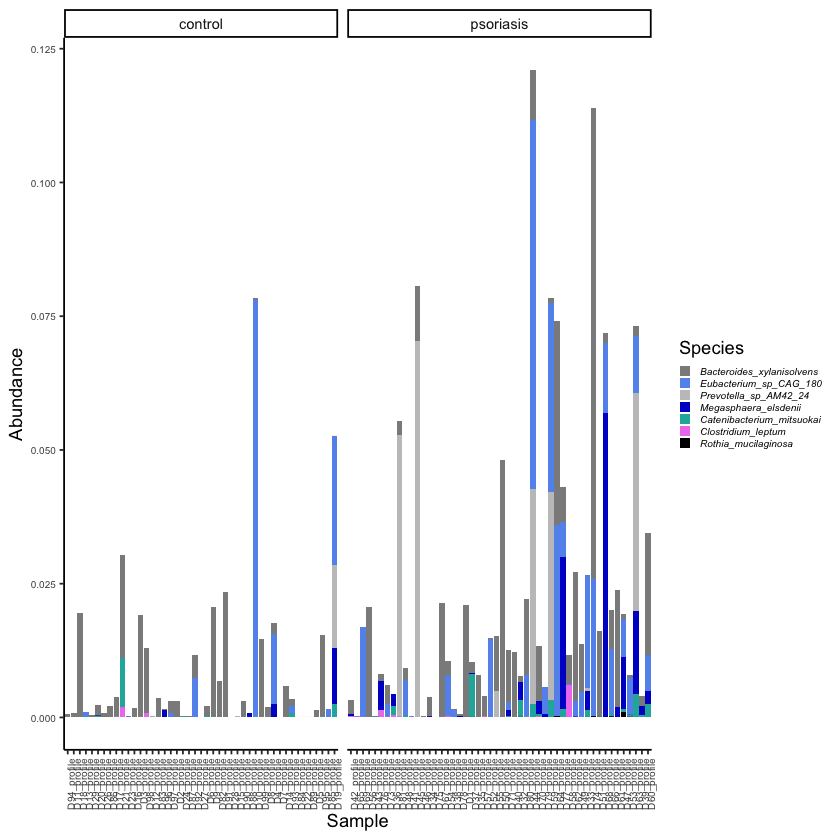

In [137]:
fp <- top7_comp_psq3_calp %>% plot_composition(sample.sort = "Calprotectin", otu.sort = "abundance", x.label = "shortID", group_by="Diagnosis") 

fp + 
    theme_classic() + 
    scale_fill_manual("Species",values = colors_bad_7) +
    theme(axis.text.x = element_text(angle=90, hjust=1, size=6),
    axis.text.y = element_text(size=6),
    legend.text = element_text(face = "italic", size=6)) + 
    theme(legend.key.size = unit(0.1, "inch"))
#dev.copy2pdf(file="Matched-Pair-Wilcox-Top-7-bad-candidates-Calprotectin-sorted.pdf",width=7,height=3.0)

In [103]:
sessionInfo()


R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.6.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: Europe/Berlin
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.3       forcats_1.0.0         stringr_1.5.1        
 [4] purrr_1.0.2           readr_2.1.5           tidyr_1.3.1          
 [7] tidyverse_2.0.0       gcookbook_2.0         tibble_3.2.1         
[10] textshape_1.7.5       compositions_2.0-8    zCompositions_1.5.0-2
[13] truncnorm_1.0-9       NADA_1.6-1.1          survival_3.5-8       
[16] plyr_1.8.9            dplyr_1.1.4           microbiome_1.24.0    
[19] PairedData_1.1.1      ggplot2_3.5.0       